In [1]:
!pip install aif360
%matplotlib inline
import sys

sys.path.append("../")
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 5.3 MB/s 


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [2]:
import shutil

original = r'/content/compas-scores-two-years.csv'
target = r'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas'

shutil.copy(original,target)

'/usr/local/lib/python3.8/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv'

In [3]:
def load_preproc_data_compas_data(protected_attributes):
    def preprocessing(df):
        df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text','sex', 'priors_count', 'days_b_screening_arrest', 'decile_score',
                 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
        
        features = ['two_year_recid','sex', 'race','age_cat', 'priors_count', 'c_charge_degree']

        def quantizeLOS(x):
            if x<= 7:
                return '<week'
            if 8<x<=93:
                return '<3months'
            else:
                return '>3 months'

        def quantizePrior(x):
            if x <=0:
                return '0'
            elif 1<=x<=3:
                return '1 to 3'
            else:
                return 'More than 3'

        def quantizeScore(x):
            if (x == 'High')| (x == 'Medium'):
                return 'MediumHigh'
            else:
                return x

        def group_race(x):
            if x == "Caucasian":
                return 1.0
            else:
                return 0.0

        def adjustAge(x):
            if x == '25 - 45':
                return '25 to 45'
            else:
                return x

        indx = df['days_b_screening_arrest'] <= 30
        indx = (df['is_recid'] != -1) & indx
        indx = (df['days_b_screening_arrest'] >= -30) & indx
        indx = (df['score_text'] != 'N/A') & indx
        indx = (df['c_charge_degree'] != "O") & indx
        
        df = df.loc[indx,:]
        df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])- pd.to_datetime(df['c_jail_in'])) / np.timedelta64(1, 'D')
        
        df_filter = df.loc[~df['race'].isin(['Native American','Hispanic','Asian','Other']),:]

        df_filter_fields = df_filter[['sex','race','age_cat','c_charge_degree','score_text','priors_count','is_recid','two_year_recid','length_of_stay']].copy()

        df_filter_fields['priors_count'] = df_filter_fields['priors_count'].apply(lambda x: quantizePrior(x))
        df_filter_fields['length_of_stay'] = df_filter_fields['length_of_stay'].apply(lambda x: quantizeLOS(x))
        df_filter_fields['score_text'] = df_filter_fields['score_text'].apply(lambda x: quantizeScore(x))
        df_filter_fields['age_cat'] = df_filter_fields['age_cat'].apply(lambda x: adjustAge(x))

        df_filter_fields['sex'] = df_filter_fields['sex'].replace({'Female': 1.0, 'Male': 0.0})
        df_filter_fields['race'] = df_filter_fields['race'].apply(lambda x: group_race(x))
        df = df_filter_fields[features]
        return df

    list_features = ['age_cat', 'c_charge_degree', 'priors_count', 'sex', 'race']
    D_features = [protected_attributes]  if protected_attributes is None else protected_attributes
    Y_features = ['two_year_recid']
    X_features = list(set(list_features)-set(D_features))
    category_features = ['age_cat', 'priors_count', 'c_charge_degree']

    all_privileged_classes = {"sex": [1.0],
                              "race": [1.0]}

    all_bias_maps = {"sex": {0.0: 'Male', 1.0: 'Female'},
                                    "race": {1.0: 'Caucasian', 0.0: 'Not Caucasian'}}


    return CompasDataset(
        label_name=Y_features[0],
        favorable_classes=[0],
        protected_attribute_names=D_features,
        privileged_classes=[all_privileged_classes[x] for x in D_features],
        instance_weights_name=None,
        categorical_features=category_features,
        features_to_keep=X_features+Y_features+D_features,
        na_values=[],
        metadata={'label_maps': [{1.0: 'Did recid.', 0.0: 'No recid.'}],
                  'protected_attribute_maps': [all_bias_maps[x]
                                for x in D_features]},
        custom_preprocessing=preprocessing)


#### Load dataset and set options

In [4]:
orig_data = load_preproc_data_compas_data(['race'])
privileged = [{'race': 1}]
non_privileged = [{'race': 0}]
orig_train_set, orig_test_set = orig_data.split([0.7], shuffle=True)

In [5]:
print("Training Dataset shape: ", orig_train_set.features.shape  )
print("Favorable and unfavorable labels: ",orig_train_set.favorable_label, orig_train_set.unfavorable_label)
print("Protected attribute names: ", orig_train_set.protected_attribute_names)
print("Dataset feature names:", orig_train_set.feature_names)

Training Dataset shape:  (3694, 10)
Favorable and unfavorable labels:  0.0 1.0
Protected attribute names:  ['race']
Dataset feature names: ['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


#### Metric for original training data

In [6]:
orig_train_metric = BinaryLabelDatasetMetric(orig_train_set, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)
print("Original training dataset...")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(orig_train_metric.mean_difference(),4)))
orig_test_metric = BinaryLabelDatasetMetric(orig_test_set, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(orig_test_metric.mean_difference(),4)))

Original training dataset...
Train set: Difference in mean outcomes between unprivileged and privileged groups =  -0.1296
Test set: Difference in mean outcomes between unprivileged and privileged groups =  -0.1389


In [7]:
scaling = MaxAbsScaler()
orig_train_set.features = scaling.fit_transform(orig_train_set.features)
orig_test_set.features = scaling.transform(orig_test_set.features)
scaled_train_metric = BinaryLabelDatasetMetric(orig_train_set, 
                             unprivileged_groups=non_privileged,
                             privileged_groups=privileged)

print("Scaled dataset - Verify that the scaling does not affect the group label statistics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(scaled_train_metric.mean_difference(),4)))
scaled_test_metric = BinaryLabelDatasetMetric(orig_test_set, 
                             unprivileged_groups=non_privileged,
                             privileged_groups=privileged)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = ",float(round(scaled_test_metric.mean_difference(),4)))


Scaled dataset - Verify that the scaling does not affect the group label statistics
Train set: Difference in mean outcomes between unprivileged and privileged groups =  -0.1296
Test set: Difference in mean outcomes between unprivileged and privileged groups =  -0.1389


### Learn plan classifier without debiasing

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
sess = tf.Session()

model_used = AdversarialDebiasing(privileged_groups = privileged,
                          unprivileged_groups = non_privileged,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess,
                          num_epochs = 200,
                          batch_size = 128)

In [9]:
model_used.fit(orig_train_set)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.698201
epoch 1; iter: 0; batch classifier loss: 0.650327
epoch 2; iter: 0; batch classifier loss: 0.598011
epoch 3; iter: 0; batch classifier loss: 0.633954
epoch 4; iter: 0; batch classifier loss: 0.644100
epoch 5; iter: 0; batch classifier loss: 0.689132
epoch 6; iter: 0; batch classifier loss: 0.630500
epoch 7; iter: 0; batch classifier loss: 0.598679
epoch 8; iter: 0; batch classifier loss: 0.655322
epoch 9; iter: 0; batch classifier loss: 0.699942
epoch 10; iter: 0; batch classifier loss: 0.680058
epoch 11; iter: 0; batch classifier loss: 0.604512
epoch 12; iter: 0; batch classifier loss: 0.621667
epoch 13; iter: 0; batch classifier loss: 0.613402
epoch 14; iter: 0; batch classifier loss: 0.619868
epoch 15; iter: 0; batch classifier loss: 0.642618
epoch 16; iter: 0; batch classifier loss: 0.626561
epoch 17; iter: 0; batch classifier loss: 0.615074
epoch 18; iter: 0; batch classifier loss: 0.616662
epoch 19; iter: 0; batch classifier loss:

In [10]:
nodebiasing_train_data = model_used.predict(orig_train_set)
nodebiasing_test_data = model_used.predict(orig_test_set)

In [11]:
nodebiasing_train_data_metric = BinaryLabelDatasetMetric(nodebiasing_train_data, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)
nodebiasing_test_data_metric = BinaryLabelDatasetMetric(nodebiasing_test_data, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)
print("Plain model - without debiasing - dataset metrics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(nodebiasing_train_data_metric.mean_difference(),4)))
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(nodebiasing_test_data_metric.mean_difference())))

nodebiasing_test_classify_metric = ClassificationMetric(orig_test_set, 
                                                 nodebiasing_test_data,
                                                 unprivileged_groups=non_privileged,
                                                 privileged_groups=privileged)
print("\nPlain model - without debiasing - classification metrics")
print("Test set: Classification accuracy = ", float(round(nodebiasing_test_classify_metric.accuracy(),4)))

bal_acc_nodebiasing_test = 0.5*(nodebiasing_test_classify_metric.true_positive_rate()+nodebiasing_test_classify_metric.true_negative_rate())
print("Test set: Balanced classification accuracy = ", float(round(bal_acc_nodebiasing_test,4)))
print("Test set: Disparate impact = ", float(round(nodebiasing_test_classify_metric.disparate_impact(),4)))
print("Test set: Equal opportunity difference = ", float(round(nodebiasing_test_classify_metric.equal_opportunity_difference(),4)))
print("Test set: Average odds difference = ", float(round(nodebiasing_test_classify_metric.average_odds_difference(),4)))
print("Test set: Theil_index = ", float(round(nodebiasing_test_classify_metric.theil_index(),4)))

Plain model - without debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups =  -0.2748
Test set: Difference in mean outcomes between unprivileged and privileged groups =  0.0

Plain model - without debiasing - classification metrics
Test set: Classification accuracy =  0.6812
Test set: Balanced classification accuracy =  0.6741
Test set: Disparate impact =  0.6565
Test set: Equal opportunity difference =  -0.1795
Test set: Average odds difference =  -0.2244
Test set: Theil_index =  0.1862


### Apply in-processing algorithm based on adversarial learning

In [12]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [13]:
debiased_model = AdversarialDebiasing(privileged_groups = privileged,
                          unprivileged_groups = non_privileged,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess,
                          num_epochs=200,
                          batch_size=128)

In [14]:
debiased_model.fit(orig_train_set)

epoch 0; iter: 0; batch classifier loss: 0.694927; batch adversarial loss: 0.772855
epoch 1; iter: 0; batch classifier loss: 0.620671; batch adversarial loss: 0.786679
epoch 2; iter: 0; batch classifier loss: 0.638709; batch adversarial loss: 0.861380
epoch 3; iter: 0; batch classifier loss: 0.622501; batch adversarial loss: 0.799589
epoch 4; iter: 0; batch classifier loss: 0.623318; batch adversarial loss: 0.874145
epoch 5; iter: 0; batch classifier loss: 0.680665; batch adversarial loss: 0.953986
epoch 6; iter: 0; batch classifier loss: 0.619786; batch adversarial loss: 0.908979
epoch 7; iter: 0; batch classifier loss: 0.623734; batch adversarial loss: 0.851198
epoch 8; iter: 0; batch classifier loss: 0.638068; batch adversarial loss: 0.803699
epoch 9; iter: 0; batch classifier loss: 0.629252; batch adversarial loss: 0.854450
epoch 10; iter: 0; batch classifier loss: 0.624048; batch adversarial loss: 0.837976
epoch 11; iter: 0; batch classifier loss: 0.608223; batch adversarial loss:

In [15]:
debiasing_train_data = debiased_model.predict(orig_train_set)
debiasing_test_data = debiased_model.predict(orig_test_set)

In [16]:
print("Plain model - without debiasing - dataset metrics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(nodebiasing_train_data_metric.mean_difference(),5)))
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(nodebiasing_test_data_metric.mean_difference(),5)))

print("\nModel - with debiasing - dataset metrics")
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(debiasing_train_data, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(metric_dataset_debiasing_train.mean_difference(),5)))

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(debiasing_test_data, 
                                             unprivileged_groups=non_privileged,
                                             privileged_groups=privileged)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = ", float(round(metric_dataset_debiasing_test.mean_difference(),5)))

print("\nPlain model - without debiasing - classification metrics")
print("Test set: Classification accuracy = ", float(round(nodebiasing_test_classify_metric.accuracy(),5)))

bal_acc_nodebiasing_test = 0.5*(nodebiasing_test_classify_metric.true_positive_rate()+nodebiasing_test_classify_metric.true_negative_rate())
print("Test set: Balanced classification accuracy = ", float(round(bal_acc_nodebiasing_test,5)))
print("Test set: Disparate impact = ",float(round(nodebiasing_test_classify_metric.disparate_impact(),5)))
print("Test set: Equal opportunity difference = ", float(round(nodebiasing_test_classify_metric.equal_opportunity_difference(),5)))
print("Test set: Average odds difference = ", float(round(nodebiasing_test_classify_metric.average_odds_difference(),5)))
print("Test set: Theil_index = ", float(round(nodebiasing_test_classify_metric.theil_index(),5)))

print("\nModel - with debiasing - classification metrics")
classified_metric_debiasing_test = ClassificationMetric(orig_test_set, debiasing_test_data, unprivileged_groups=non_privileged, privileged_groups=privileged)
print("Test set: Classification accuracy = ", float(round(classified_metric_debiasing_test.accuracy(),4)))

bal_acc_debiasing_test = (classified_metric_debiasing_test.true_positive_rate()+classified_metric_debiasing_test.true_negative_rate())/2
print("Test set: Balanced classification accuracy = ", float(round( bal_acc_debiasing_test,5)))
print("Test set: Disparate impact = ", float(round(classified_metric_debiasing_test.disparate_impact(),5)))
print("Test set: Equal opportunity difference = ", float(round(classified_metric_debiasing_test.equal_opportunity_difference(),5)))
print("Test set: Average odds difference = ", float(round(classified_metric_debiasing_test.average_odds_difference(),5)))
print("Test set: Theil_index = ", float(round(classified_metric_debiasing_test.theil_index(),5)))

Plain model - without debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups =  -0.27483
Test set: Difference in mean outcomes between unprivileged and privileged groups =  -0.26248

Model - with debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups =  -0.0637
Test set: Difference in mean outcomes between unprivileged and privileged groups =  -0.04676

Plain model - without debiasing - classification metrics
Test set: Classification accuracy =  0.68119
Test set: Balanced classification accuracy =  0.67415
Test set: Disparate impact =  0.65645
Test set: Equal opportunity difference =  -0.17953
Test set: Average odds difference =  -0.22444
Test set: Theil_index =  0.18615

Model - with debiasing - classification metrics
Test set: Classification accuracy =  0.6648
Test set: Balanced classification accuracy =  0.66155
Test set: Disparate impact =  0.91974
Test set: Equal opportuni

In [17]:
def plot_comparison_graphs(X,y):

    plt.subplot(1, 2, 1)
    lst = [X.disparate_impact(),y.disparate_impact() ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,2)
    plt.title('Disparate impact')
    plt.subplot(1, 2, 2)
    lst=[X.equal_opportunity_difference(),y.equal_opportunity_difference() ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Equal opportunity difference')
    plt.ylim(-0.5,2)
    plt.show()

    plt.subplot(1, 2, 1)
    lst=[X.average_odds_difference(),y.average_odds_difference() ]
    plt.bar(['before','after'],lst , width=0.2)
    plt.ylim(-0.5,0.5)
    plt.title('Average odds difference')
    plt.subplot(1, 2, 2)
    lst=[X.theil_index(),y.theil_index()]
    plt.bar(['before','after'],lst , width=0.2)
    plt.title('Theil index')
    plt.ylim(-0.25,0.25)
    plt.show()

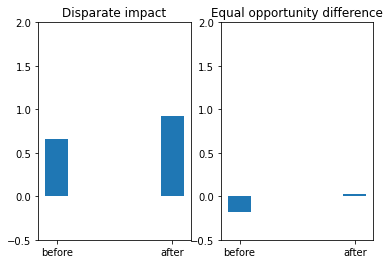

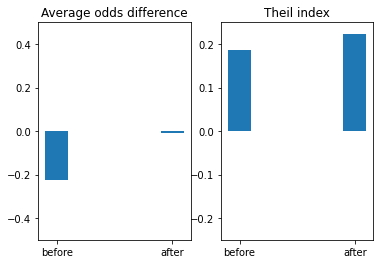

In [18]:
plot_comparison_graphs(nodebiasing_test_classify_metric, classified_metric_debiasing_test)